# Durable benefit analysis
Build a classifier that predict durable benefit (defined as progression free survival greater or equal half a year).

In [1]:
from matplotlib import pyplot as plt
from numpy import array
import optuna
from pandas import DataFrame
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import roc_auc_score

import shap

In [2]:
# Add parent directory to path.
import os
import sys

sys.path.insert(1, os.path.join(sys.path[0], ".."))

In [3]:
from ctdna.dataset import load_splits
from ctdna.metrics import classification_report, youden_j
from ctdna.model.architectures import (
    build_train_clinical_ctdna_model,
    build_train_ctdna_model,
    tune_pseudocount,
)
from ctdna.model.classifiers import NBPomegranate
from ctdna.model.distributions import Bernoulli
from ctdna.model.utils import compute_sample_weights
from ctdna.plot.views import (
    confidence_interval_label,
    plot_precision_recall,
    plot_roc_curve,
    plot_stratified_roc_curve,
    plot_variants,
    polish_features,
    waterfall,
)
from ctdna.statistics import bootstrap_score, paired_permutation_test, unpaired_permutation_test 
from ctdna.vcf.preprocessing import (
    VcfDataGenerator,
    gene_ratio_layer,
    molecular_response_layer,
    select_next_follow_up,
)
from ctdna.utils import stratified_score

In [4]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
shap.initjs()

In [5]:
df_train, df_dev, df_test = load_splits()

Compute the following features:
- Follow-up ($t_1$) over baseline ($t_0$) ratio of the most abundant baseline mutant, across several genes.
- Molecular response: a 50 % reduction in the largest baseline mutant.

In [6]:
dg = VcfDataGenerator(
    transformations=[
        gene_ratio_layer,
        molecular_response_layer,
    ],
    filters=select_next_follow_up,
)
X_train, y_train = dg.flow_from_dataframe(df_train, keep_columns=True)
weights = compute_sample_weights(X_train)

X_dev, y_dev = dg.flow_from_dataframe(df_dev, keep_columns=True)
X_test, y_test = dg.flow_from_dataframe(df_test, keep_columns=True)

to_binary = {"pfs≥6months": 1, "pfs<6months": 0}
y_train = y_train.replace(to_binary)
y_dev = y_dev.replace(to_binary)
y_test = y_test.replace(to_binary)

Also collect the raw variants (we don't transform these variants) for visualisation.

In [7]:
X_train_raw, _ = VcfDataGenerator(filters=select_next_follow_up).flow_from_dataframe(
    df_train, keep_columns=False, drop_time=False
)
X_dev_raw, _ = VcfDataGenerator(filters=select_next_follow_up).flow_from_dataframe(
    df_dev, keep_columns=False, drop_time=False
)
X_test_raw, _ = VcfDataGenerator(filters=select_next_follow_up).flow_from_dataframe(
    df_test, keep_columns=False, drop_time=False
)

X_train_raw = X_train_raw.droplevel("platform")
X_dev_raw = X_dev_raw.droplevel("platform")
X_test_raw = X_test_raw.droplevel("platform")

Remove variables that we will not use in our analyses.

In [8]:
to_drop = [
    "PS (ECOG) ≥ 2",
    "clinical_response",
    "os_event",
    "os_months",
    "pfs_event",
    "pfs_months",
    "response_grouped",
    "therapy",
]
X_train.drop(columns=to_drop, inplace=True)
X_dev.drop(columns=to_drop, inplace=True)
X_test.drop(columns=to_drop, inplace=True)

In [9]:
benchmark = DataFrame(
    index=["clinical", "MR", "multitrack", "clinical + multitrack"],
    columns=["point", "lower", "upper"],
)

# Clinical characteristics
Classifier that only uses the three most predictive clinical features (as determined in `backward feature selection.ipynb`).

In [10]:
distributions = {
    "smoker": Bernoulli,
    "therapyline>1": Bernoulli,
    "histology_squamous": Bernoulli,
}
features = list(distributions.keys())

In [11]:
hyperparams = tune_pseudocount(distributions, X_train, y_train, X_dev, y_dev)

In [12]:
# Train.
m = NBPomegranate(distributions, **hyperparams).fit(X_train[features], y_train, weights)

In [13]:
y_test_prob = m.predict_proba(X_test[features]).iloc[:, 1]
y_test_pred_clin = y_test_prob.copy()
test_score = stratified_score(y_test, y_test_pred_clin, metric=roc_auc_score)
print("Score on test set")
print(test_score)

Score on test set
                            point     lower     upper
overall                  0.612519   0.48833  0.738771
Anagnostou et al. ('19)      0.75       0.5       1.0
Nabet et al. ('20)       0.408163     0.125  0.708403
Thompson et al. ('21)    0.588889  0.318182     0.875
Weber et al. ('21)       0.576446    0.3871   0.75277
Zou et al. ('21)         0.666667       0.5  0.857143


In [14]:
benchmark.loc["clinical"] = test_score.loc["overall"]

# Molecular response
This is the traditional molecular response marker, indicating a 50 % reducting in the largest baseline variant.

In [15]:
distributions = {r"hvaf>50%red": Bernoulli}
features = list(distributions.keys())

In [16]:
hyperparams = tune_pseudocount(distributions, X_train, y_train, X_dev, y_dev)
hyperparams

{'pseudo_count': 2.060449286627467}

In [17]:
# Train.
m = NBPomegranate(distributions, **hyperparams).fit(X_train[features], y_train, weights)

In [18]:
y_train_prob = m.predict_proba(X_train[features]).iloc[:, 1]
train_score = stratified_score(y_train, y_train_prob, metric=roc_auc_score)
print("Score on train set")
print(train_score)

Score on train set
                            point     lower     upper
overall                  0.682419  0.615715  0.744923
Anagnostou et al. ('19)      0.75     0.375       1.0
Nabet et al. ('20)       0.720779  0.577499  0.856691
Thompson et al. ('21)    0.698006  0.539484   0.84375
Weber et al. ('21)       0.606952  0.508461  0.708964
Zou et al. ('21)         0.730994  0.540891  0.895937


In [19]:
y_dev_prob = m.predict_proba(X_dev[features]).iloc[:, 1]
dev_score = stratified_score(y_dev, y_dev_prob, metric=roc_auc_score)
print("Score on dev set")
print(dev_score)

Score on dev set
                            point     lower     upper
overall                  0.650379  0.542289  0.761321
Anagnostou et al. ('19)       1.0       1.0       1.0
Nabet et al. ('20)       0.660714       0.4     0.875
Thompson et al. ('21)      0.5625      0.25     0.875
Weber et al. ('21)       0.594697   0.43149  0.761975
Zou et al. ('21)         0.583333   0.30625  0.928571


In [20]:
y_test_prob = m.predict_proba(X_test[features]).iloc[:, 1]
y_test_prob_mr = y_test_prob
test_score = stratified_score(y_test, y_test_prob, metric=roc_auc_score)
print("Score on test set")
print(test_score)

Score on test set
                            point     lower     upper
overall                  0.639785  0.534153  0.749586
Anagnostou et al. ('19)      0.75       0.5       1.0
Nabet et al. ('20)       0.642857     0.375       0.9
Thompson et al. ('21)    0.522222      0.25  0.791667
Weber et al. ('21)       0.659091  0.497826  0.833507
Zou et al. ('21)             0.75       0.5  0.928571


In [21]:
benchmark.loc["MR"] = test_score.loc["overall"]

In [22]:
confidence_interval_label(test_score.loc["overall"], latex=False)

'0.64 (95 % CI: 0.53-0.75)'

# Multitrack model (no clinical data)
Use the seven selected genes (`APC`, `BRCA2`, `EGFR`, `NFE2L2`, `PDGFRA`, `PIK3CA`, and `TP53`) with the inflated log normal distribution.

In [23]:
m = build_train_ctdna_model(X_train, y_train, X_dev, y_dev)
features = list(m.distributions.keys())

Tuning pseudo counts...
{'pseudo_count': 1.2664296373528532}
Re-training tuned model... [DONE]


In [24]:
y_train_prob = m.predict_proba(X_train[features]).iloc[:, 1]
train_score = stratified_score(y_train, y_train_prob, metric=roc_auc_score)
print("Score on train set")
print(train_score)

Score on train set
                            point     lower     upper
overall                  0.818343  0.760727  0.867688
Anagnostou et al. ('19)   0.71875  0.266667       1.0
Nabet et al. ('20)       0.775974  0.641056  0.893668
Thompson et al. ('21)      0.7849  0.633911  0.905963
Weber et al. ('21)         0.7959  0.705539  0.879011
Zou et al. ('21)         0.906433  0.729132       1.0


In [25]:
y_dev_prob = m.predict_proba(X_dev[features]).iloc[:, 1]
dev_score = stratified_score(y_dev, y_dev_prob, metric=roc_auc_score)
print("Score on dev set")
print(dev_score)

Score on dev set
                            point     lower     upper
overall                  0.750379  0.629163  0.857918
Anagnostou et al. ('19)       1.0       1.0       1.0
Nabet et al. ('20)       0.839286      0.58       1.0
Thompson et al. ('21)    0.671875   0.34375  0.938304
Weber et al. ('21)       0.702652   0.49277    0.8789
Zou et al. ('21)         0.611111      0.25      0.95


Compute probability threshold to dichotomise probability in class assignment at Youden's J.

In [26]:
threshold_multitrack = youden_j(y_dev, y_dev_prob)
threshold_multitrack

0.46066607533663007

In [27]:
y_test_prob = m.predict_proba(X_test[features]).iloc[:, 1]
y_test_prob_multitrack = y_test_prob.copy()
test_score = stratified_score(y_test, y_test_prob_multitrack, metric=roc_auc_score)
print("Score on test set")
print(test_score)

Score on test set
                            point     lower     upper
overall                  0.773425  0.666109  0.869725
Anagnostou et al. ('19)      0.75       0.5       1.0
Nabet et al. ('20)        0.77551       0.5   0.96875
Thompson et al. ('21)    0.844444  0.582292       1.0
Weber et al. ('21)       0.698347  0.487378   0.87652
Zou et al. ('21)         0.916667    0.6875       1.0


In [28]:
benchmark.loc["multitrack"] = test_score.loc["overall"]

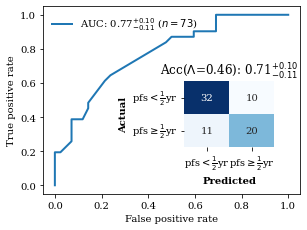

In [29]:
plt.figure(figsize=(4 * 1.15, 3 * 1.15))
plt.rc("font", family="serif")
classes = [r"pfs$<\frac{1}{2}$yr", r"pfs$\geq \frac{1}{2}$yr"]
plot_roc_curve(
    y_test, y_test_prob_multitrack, threshold=threshold_multitrack, labels=classes
)
plt.savefig("figs/pfs/multitrack/roc.eps", bbox_inches="tight")
plt.savefig("figs/pfs/multitrack/roc.png", bbox_inches="tight")
plt.savefig("figs/pfs/multitrack/roc.pdf", bbox_inches="tight")
plt.savefig("figs/pfs/multitrack/roc.svg", bbox_inches="tight")

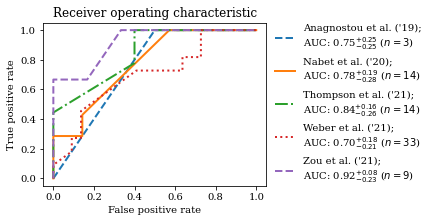

In [30]:
plt.figure(figsize=(4, 3))
plt.rc("font", family="serif")
plot_stratified_roc_curve(y_test, y_test_prob_multitrack)

plt.savefig("figs/pfs/multitrack/roc_per_dataset.png", bbox_inches="tight")
plt.savefig("figs/pfs/multitrack/roc_per_dataset.eps", bbox_inches="tight")
plt.savefig("figs/pfs/multitrack/roc_per_dataset.pdf", bbox_inches="tight")
plt.savefig("figs/pfs/multitrack/roc_per_dataset.svg", bbox_inches="tight")

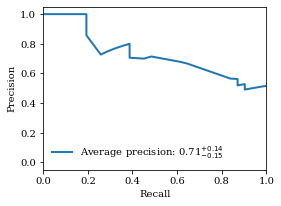

In [31]:
plt.figure(figsize=(4, 3))
plot_precision_recall(y_test, y_test_prob_multitrack)
plt.savefig("figs/pfs/multitrack/precision_recall.eps", bbox_inches="tight")
plt.savefig("figs/pfs/multitrack/precision_recall.png", bbox_inches="tight")
plt.savefig("figs/pfs/multitrack/precision_recall.pdf", bbox_inches="tight")
plt.savefig("figs/pfs/multitrack/precision_recall.svg", bbox_inches="tight")

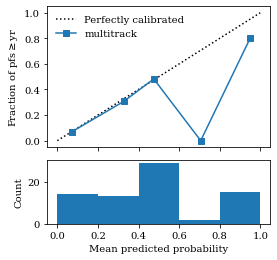

In [32]:
f = plt.figure(figsize=(4, 4))
plt.rc("font", family="serif")

name = "multitrack"
gs = f.add_gridspec(3, 1)
ax2 = f.add_subplot(gs[2])
ax = f.add_subplot(gs[:2], sharex=ax2)
cd = CalibrationDisplay.from_estimator(
    m,
    X_test[features].to_numpy(),
    y_test,
    ax=ax,
    name=name,
)
ax.set_ylabel("Fraction of pfs$\geq \frac{1}{2}$yr")
plt.legend(frameon=False)


ax2.hist(
    cd.y_prob,
    range=(0, 1),
    bins=5,
    label=name,
)
plt.setp(ax.get_xticklabels(), visible=False)
ax.set_xlabel("")

ax2.set(xlabel="Mean predicted probability", ylabel="Count")
plt.savefig("figs/pfs/multitrack/calibration.eps", bbox_inches="tight")
plt.savefig("figs/pfs/multitrack/calibration.png", bbox_inches="tight")
plt.savefig("figs/pfs/multitrack/calibration.pdf", bbox_inches="tight")
plt.savefig("figs/pfs/multitrack/calibration.svg", bbox_inches="tight")

# Full model (with clinical data)
Uses both the aforementioned 7 gene tracks as well as the three most predictive clinical characteristics (`therapy line`, `histology`, and `smoking status`).

In [33]:
m = build_train_clinical_ctdna_model(X_train, y_train, X_dev, y_dev)
features = list(m.distributions.keys())

Tuning pseudo counts...
{'pseudo_count': {<class 'ctdna.model.distributions.Bernoulli'>: 2.672796686466822, <class 'ctdna.model.distributions.InflatedPinnedLogNormal'>: 1.0966835925885896}}
Re-training tuned model... [DONE]


In [34]:
y_train_prob = m.predict_proba(X_train[features]).iloc[:, 1]
train_score = stratified_score(y_train, y_train_prob, metric=roc_auc_score)
print("Score on train set")
print(train_score)

Score on train set
                            point     lower     upper
overall                  0.834307  0.777349  0.880604
Anagnostou et al. ('19)    0.8125  0.428571       1.0
Nabet et al. ('20)       0.734848  0.571727  0.878803
Thompson et al. ('21)    0.840456  0.703066  0.946739
Weber et al. ('21)       0.790107  0.689606  0.876037
Zou et al. ('21)         0.923977  0.742301       1.0


In [35]:
y_dev_prob = m.predict_proba(X_dev[features]).iloc[:, 1]
dev_score = stratified_score(y_dev, y_dev_prob, metric=roc_auc_score)
print("Score on dev set")
print(dev_score)

Score on dev set
                            point     lower     upper
overall                   0.79053  0.677583  0.891908
Anagnostou et al. ('19)       1.0       1.0       1.0
Nabet et al. ('20)            1.0       1.0       1.0
Thompson et al. ('21)     0.71875  0.362662       1.0
Weber et al. ('21)       0.702652   0.49277    0.8789
Zou et al. ('21)         0.638889      0.25       1.0


We set the oprating point at Youden's J, which we compute on the development set.

In [36]:
threshold_clin_multitrack = youden_j(y_dev, y_dev_prob)
threshold_clin_multitrack

0.40028036399023414

In [37]:
y_test_prob = m.predict_proba(X_test[features]).iloc[:, 1]
y_test_prob_clin_multitrack = y_test_prob.copy()
y_test_pred = (y_test_prob_clin_multitrack > threshold_clin_multitrack).astype(int)
test_score = stratified_score(y_test, y_test_prob_clin_multitrack, metric=roc_auc_score)
print("Score on test set")
print(test_score)

Score on test set
                            point     lower     upper
overall                  0.800307  0.698633  0.892668
Anagnostou et al. ('19)      0.75       0.5       1.0
Nabet et al. ('20)       0.663265  0.333125    0.9375
Thompson et al. ('21)         0.9  0.686875       1.0
Weber et al. ('21)        0.72314  0.519185  0.904364
Zou et al. ('21)         0.916667    0.6875       1.0


In [38]:
benchmark.loc["clinical + multitrack"] = test_score.loc["overall"]

In [39]:
cm_score = test_score.apply(confidence_interval_label, axis=1).replace(
    {"\$": ""}, regex=True
)
cm_score.to_clipboard(excel=True)
cm_score

overall                    0.80^{+0.09}_{-0.10}
Anagnostou et al. ('19)    0.75^{+0.25}_{-0.25}
Nabet et al. ('20)         0.66^{+0.27}_{-0.33}
Thompson et al. ('21)      0.90^{+0.10}_{-0.21}
Weber et al. ('21)         0.72^{+0.18}_{-0.20}
Zou et al. ('21)           0.92^{+0.08}_{-0.23}
dtype: object

### Number of detected mutations calibration
Some patients may have no mutations in this seven gene set, and some may have many. How does the model perform, depending on how many genes were hit? 
Here, we make a compare performance as a function of used variants:

In [65]:
def stratify_roc_auc_by_mutations(X, y_true, y_prob):
    """Score as a function of detected genes."""
    n_mutations = []
    n_samples = []
    values = []
    errors = []

    genes = ['APC', 'BRCA2', 'EGFR', 'NFE2L2', 'PDGFRA', 'PIK3CA', 'TP53']
    is_detected = (X[genes].notna() & (X[genes] != 1.0)).astype(int)
    n_detected = is_detected.sum(axis=1)
    for count in sorted(n_detected.unique()):
        idx_with_n = n_detected == count
        n_patients = y_true[idx_with_n].shape[0]
        score = bootstrap_score(y_true[idx_with_n], y_prob[idx_with_n], metric=roc_auc_score)
        print('ROC AUC', confidence_interval_label(score, latex=False), f'(n = {n_patients})')
        print(confidence_interval_label(score, latex=True))
        n_mutations.append(count)
        values.append(score['point'])
        errors.append([score['point'] - score['lower'], score['upper'] - score['point']])
        n_samples.append(n_patients)

    return array(n_mutations), array(n_samples), array(values), array(errors).T

In [70]:
genes = ['APC', 'BRCA2', 'EGFR', 'NFE2L2', 'PDGFRA', 'PIK3CA', 'TP53']
is_detected = (X_test[genes].notna() & (X_test[genes] != 1.0)).astype(int)
n_detected = is_detected.sum(axis=1)

unpaired_permutation_test(y_test, y_test_prob_clin_multitrack[n_detected == 0], y_test_prob_clin_multitrack[n_detected > 0], metric=roc_auc_score)

(-0.12857142857142856, 0.239)

In [66]:
n_mutations, n_samples, values, errors = stratify_roc_auc_by_mutations(X_test, y_test, y_test_prob_clin_multitrack)

ROC AUC 0.71 (95 % CI: 0.47-0.91) (n = 25)
0.71$^{+0.19}_{-0.24}$
ROC AUC 0.64 (95 % CI: 0.43-0.82) (n = 28)
0.64$^{+0.18}_{-0.21}$
ROC AUC 0.96 (95 % CI: 0.83-1.00) (n = 14)
0.96$^{+0.04}_{-0.13}$
ROC AUC 1.00 (95 % CI: 1.00-1.00) (n = 4)
1.00$^{+0.00}_{0.00}$
ROC AUC 1.00 (95 % CI: 1.00-1.00) (n = 2)
1.00$^{+0.00}_{0.00}$


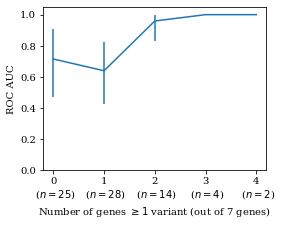

In [67]:
plt.figure(figsize=(4,3))
plt.errorbar(n_mutations, values, yerr=errors)
plt.xticks(ticks=n_mutations, labels=[f'{i}\n ($n={n_samples[i]}$)' for i in range(len(n_mutations))])
plt.xlabel('Number of genes $\geq 1$ variant (out of 7 genes)')
plt.ylabel('ROC AUC')
plt.ylim([0,1.05])
plt.savefig("figs/pfs/clinical_multitrack/roc_auc_by_detections.eps", bbox_inches="tight")
plt.savefig("figs/pfs/clinical_multitrack/roc_auc_by_detections.png", bbox_inches="tight")
plt.savefig("figs/pfs/clinical_multitrack/roc_auc_by_detections.pdf", bbox_inches="tight")
plt.savefig("figs/pfs/clinical_multitrack/roc_auc_by_detections.svg", bbox_inches="tight")

#### Receiver operating characteristic curve
On test set, including confusion matrix of actual predictions, dichotomised using the earlier determined threshold (at J).

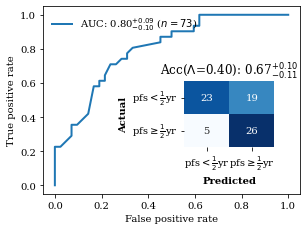

In [43]:
plt.figure(figsize=(4 * 1.15, 3 * 1.15))
plt.rc("font", family="serif")
classes = [r"pfs$<\frac{1}{2}$yr", r"pfs$\geq \frac{1}{2}$yr"]
plot_roc_curve(
    y_test,
    y_test_prob_clin_multitrack,
    threshold=threshold_clin_multitrack,
    labels=classes,
)
plt.savefig("figs/pfs/clinical_multitrack/roc.eps", bbox_inches="tight")
plt.savefig("figs/pfs/clinical_multitrack/roc.png", bbox_inches="tight")
plt.savefig("figs/pfs/clinical_multitrack/roc.pdf", bbox_inches="tight")
plt.savefig("figs/pfs/clinical_multitrack/roc.svg", bbox_inches="tight")

#### ROC curve stratified by dataset
Stratify ROC AUC per cohort, or equivalently, by platform.

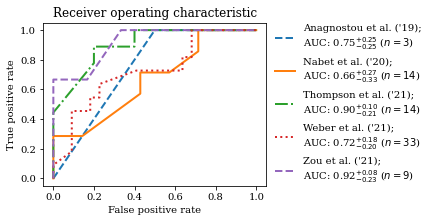

In [44]:
plt.figure(figsize=(4, 3))
plt.rc("font", family="serif")
plot_stratified_roc_curve(y_test, y_test_prob_clin_multitrack)

plt.savefig("figs/pfs/clinical_multitrack/roc_per_dataset.png", bbox_inches="tight")
plt.savefig("figs/pfs/clinical_multitrack/roc_per_dataset.eps", bbox_inches="tight")
plt.savefig("figs/pfs/clinical_multitrack/roc_per_dataset.pdf", bbox_inches="tight")
plt.savefig("figs/pfs/clinical_multitrack/roc_per_dataset.svg", bbox_inches="tight")

Test if Nabet et al. is significantly worse than the complement.

In [45]:
is_nabet = y_test.index.map(lambda x: "NABE" in x)
not_nabet = y_test.index.map(lambda x: "NABE" not in x)
y_pred_nabe = y_test_prob_clin_multitrack.loc[is_nabet]
y_pred_other = y_test_prob_clin_multitrack.loc[not_nabet]
diff, pvalue = unpaired_permutation_test(
    y_test, y_pred_nabe, y_pred_other, metric=roc_auc_score
)
print(f"Is Nabet significantly worse? p={pvalue}")

Is Nabet significantly worse? p=0.23023023023023023


In [46]:
is_thom = y_test.index.map(lambda x: "THOM" in x)
not_thom = y_test.index.map(lambda x: "THOM" not in x)
y_pred_thom = y_test_prob_clin_multitrack.loc[is_thom]
y_pred_notthom = y_test_prob_clin_multitrack.loc[not_thom]
diff, pvalue = unpaired_permutation_test(
    y_test, y_pred_notthom, y_pred_thom, metric=roc_auc_score
)
print(f"Is Thompson significantly better? p={pvalue}")

Is Thompson significantly better? p=0.33


#### Precision recall curve

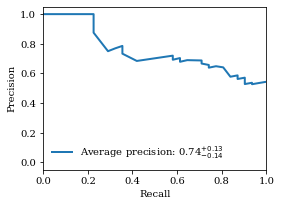

In [47]:
plt.figure(figsize=(4, 3))
plot_precision_recall(y_test, y_test_prob_clin_multitrack)
plt.savefig("figs/pfs/clinical_multitrack/precision_recall.eps", bbox_inches="tight")
plt.savefig("figs/pfs/clinical_multitrack/precision_recall.png", bbox_inches="tight")
plt.savefig("figs/pfs/clinical_multitrack/precision_recall.pdf", bbox_inches="tight")
plt.savefig("figs/pfs/clinical_multitrack/precision_recall.svg", bbox_inches="tight")

#### Calibration curve

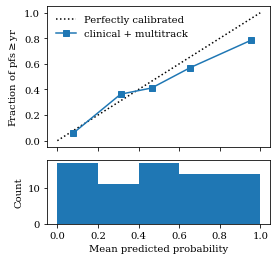

In [48]:
f = plt.figure(figsize=(4, 4))
plt.rc("font", family="serif")

name = "clinical + multitrack"
gs = f.add_gridspec(3, 1)
ax2 = f.add_subplot(gs[2])
ax = f.add_subplot(gs[:2], sharex=ax2)
cd = CalibrationDisplay.from_estimator(
    m,
    X_test[features].to_numpy(),
    y_test,
    ax=ax,
    name=name,
)
ax.set_ylabel("Fraction of pfs$\geq \frac{1}{2}$yr")
plt.legend(frameon=False)


ax2.hist(
    cd.y_prob,
    range=(0, 1),
    bins=5,
    label=name,
)
plt.setp(ax.get_xticklabels(), visible=False)
ax.set_xlabel("")

ax2.set(xlabel="Mean predicted probability", ylabel="Count")

plt.savefig("figs/pfs/clinical_multitrack/calibration.eps", bbox_inches="tight")
plt.savefig("figs/pfs/clinical_multitrack/calibration.png", bbox_inches="tight")
plt.savefig("figs/pfs/clinical_multitrack/calibration.pdf", bbox_inches="tight")
plt.savefig("figs/pfs/clinical_multitrack/calibration.svg", bbox_inches="tight")

# Model overview

color is redundantly defined by the 'color' keyword argument and the fmt string "r.-" (-> color='r'). The keyword argument will take precedence.


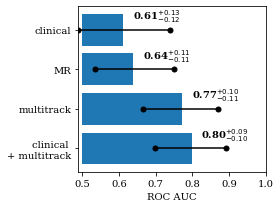

In [49]:
n_y = len(benchmark)
fig, ax = plt.subplots(figsize=(4, 3))
plt.rc("font", family="serif")
y_pos = list(range(n_y))[::-1]
left = array([0.0] + list(benchmark["point"][:-1]))

improvements = benchmark["point"] - left
# ax.barh(y_pos, width=improvements, left=left)
ax.barh(y_pos, width=benchmark["point"] - 0.5, left=0.5)

for i, y_i in enumerate(y_pos):
    score_i = benchmark.iloc[i]
    plt.plot(
        (score_i["lower"], score_i["upper"]),
        (y_i, y_i),
        "r.-",
        color="black",
        linewidth=1.5,
        markersize=10,
    )

plt.yticks(y_pos, list(benchmark.index))
plt.xlabel("ROC AUC (95 % confidence interval)")
plt.xlim([0.45, 1.05])

x_offset = 0.025
y_offset = 0.35
for i in range(n_y):
    label = confidence_interval_label(benchmark.iloc[i], latex=True)
    ax.text(
        benchmark["point"][i] + x_offset,
        y_pos[i] + y_offset,
        label,
        #         color=text_color,
        weight="bold",
        verticalalignment="center",
        wrap=True,
    )

ax.set_yticks(y_pos)
ax.set_yticklabels(
    [label.replace("+", "\n+") if "+" in label else label for label in benchmark.index]
)
plt.xlim([0.49, 1])
plt.xlabel("ROC AUC")
plt.tight_layout()
plt.savefig("figs/benchmark.eps")
plt.savefig("figs/benchmark.png")
plt.savefig("figs/benchmark.pdf")
plt.savefig("figs/benchmark.svg")

In [50]:
benchmark_latex = benchmark.apply(confidence_interval_label, axis=1).replace(
    {"\$": ""}, regex=True
)
benchmark_latex.to_clipboard(excel=True)
benchmark_latex

clinical                 0.61^{+0.13}_{-0.12}
MR                       0.64^{+0.11}_{-0.11}
multitrack               0.77^{+0.10}_{-0.11}
clinical + multitrack    0.80^{+0.09}_{-0.10}
dtype: object

Is the ctDNA model significantly better than the molecular response model? Lets do a permutation test with 1000 iterations to compute the p-value.

In [51]:
paired_permutation_test(
    y_test,
    y_test_prob_multitrack,
    y_test_prob_mr,
    metric=roc_auc_score,
)

(0.13364055299539168, 0.029)

Similarly, we will also do a permutation test to compute the p-value for the clinical + ctDNA model: 

In [52]:
paired_permutation_test(
    y_test,
    y_test_prob_clin_multitrack,
    y_test_prob_mr,
    metric=roc_auc_score,
)

(0.16052227342549907, 0.005)

In [53]:
report = DataFrame(
    {
        "multitrack": classification_report(
            y_test, y_test_prob_multitrack, threshold_multitrack
        ),
        "clinical + multitrack": classification_report(
            y_test, y_test_prob_clin_multitrack, threshold_clin_multitrack
        ),
    }
).T

In [54]:
report.replace({"\$": ""}, regex=True).to_clipboard(excel=True)
report

ROC AUC                Accuracy  \
multitrack             0.77$^{+0.10}_{-0.11}$  0.71$^{+0.10}_{-0.11}$   
clinical + multitrack  0.80$^{+0.09}_{-0.10}$  0.67$^{+0.10}_{-0.11}$   

                                  Sensitivity             Specificity  \
multitrack             0.65$^{+0.15}_{-0.19}$  0.76$^{+0.12}_{-0.12}$   
clinical + multitrack  0.84$^{+0.13}_{-0.14}$  0.55$^{+0.15}_{-0.15}$   

                            Average precision                   $F_1$  
multitrack             0.71$^{+0.14}_{-0.15}$  0.66$^{+0.13}_{-0.16}$  
clinical + multitrack  0.74$^{+0.13}_{-0.14}$  0.68$^{+0.11}_{-0.13}$

In [55]:
def explain(estimator, X, X_raw, target_name="pfs≥½ yr", save_path=None):
    """Compute and plot feature importance for prediction."""
    importance = estimator.feature_importance(X)
    X_shap_polished = polish_features(X)

    plots = []
    for idx, row in X.iterrows():
        f_water = waterfall(
            expected_value=0.0,
            shap_values=importance.loc[idx],
            features=X_shap_polished.loc[idx],
            feature_names=importance.columns,
            target_label=target_name,
            logit=True,
            max_display=6,
            show=False,
        )
        plots.append(f_water)
        plt.show()
        f_vaf = plt.figure(figsize=(3, 2))
        plot_variants(X_raw.loc[idx])
        plt.title(str(idx))

        if save_path is not None:
            f_vaf.savefig(f"{save_path}/{idx}_variants.pdf", bbox_inches="tight")
            f_vaf.savefig(f"{save_path}/{idx}_variants.eps", bbox_inches="tight")
            f_vaf.savefig(f"{save_path}/{idx}_variants.svg", bbox_inches="tight")
            f_vaf.savefig(f"{save_path}/{idx}_variants.png", bbox_inches="tight")
            f_water.savefig(f"{save_path}/{idx}_water.pdf", bbox_inches="tight")
            f_water.savefig(f"{save_path}/{idx}_water.eps", bbox_inches="tight")
            f_water.savefig(f"{save_path}/{idx}_water.svg", bbox_inches="tight")
            f_water.savefig(f"{save_path}/{idx}_water.png", bbox_inches="tight")
        plt.show()
    return plots


# Top 4 best
On test set, two for each target label (`c=1` and `c=0`), which are thefore the most accurate true postive (`c=1`), and most accurate true negative (`c=0`).

In [56]:
y1 = y_test == 1
y0 = y_test == 0
diff = abs(y_test_prob - y_test).sort_values()

top2_y1 = diff[y1].index[:2]
top2_y0 = diff[y0].index[:2]
worst2_y1 = diff[y1][::-1].index[:2]
worst2_y0 = diff[y0][::-1].index[:2]

## Positive target
Compute log-likelihood ratio per feature to illustrate feature importance.

Index(['smoker', 'therapyline>1', 'histology_squamous'], dtype='object')


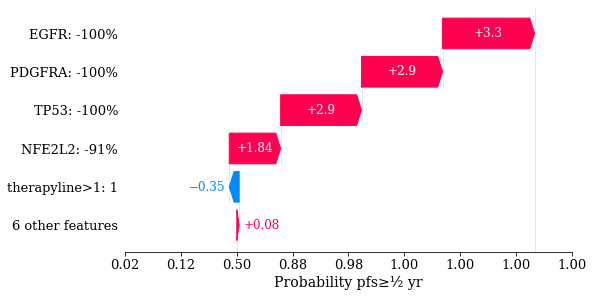

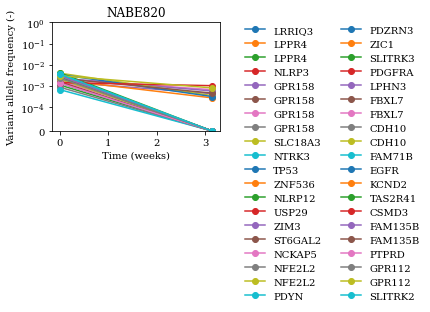

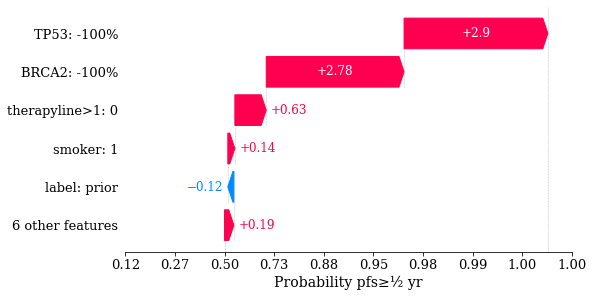

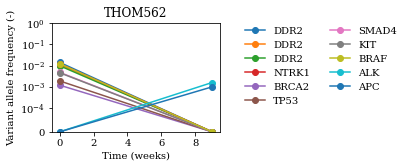

[<Figure size 576x324 with 1 Axes>, <Figure size 576x324 with 1 Axes>]

In [57]:
explain(
    m,
    X_test[features].loc[top2_y1, features],
    X_test_raw,
    save_path="figs/pfs/clinical_multitrack/best",
)

## Negative target

Index(['smoker', 'therapyline>1', 'histology_squamous'], dtype='object')


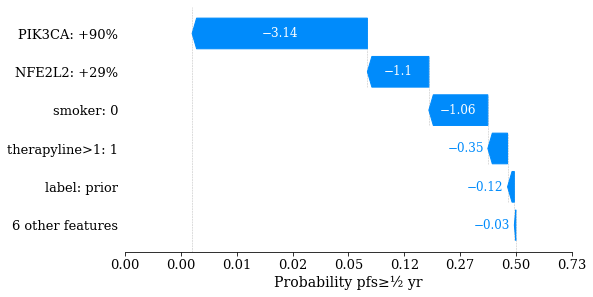

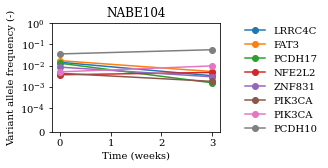

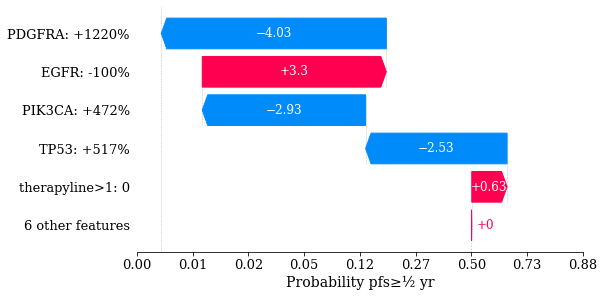

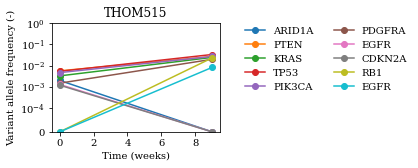

[<Figure size 576x324 with 1 Axes>, <Figure size 576x324 with 1 Axes>]

In [58]:
explain(
    m,
    X_test.loc[top2_y0, features],
    X_test_raw,
    save_path="figs/pfs/clinical_multitrack/best",
)

# Top 4 worst
Now do the same for the misclassifications. So the most inaccurate prediction for the positive class (false positive), and most inaccurate prediction for the negative class (false negative).
## Positive target

Index(['smoker', 'therapyline>1', 'histology_squamous'], dtype='object')


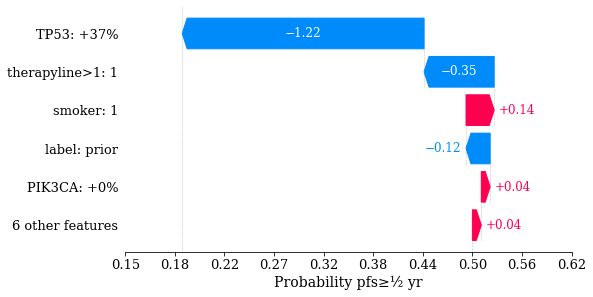

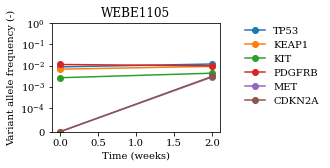

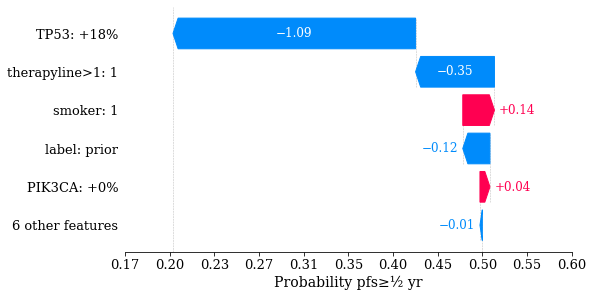

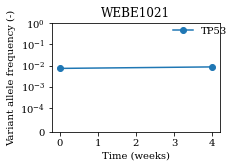

[<Figure size 576x324 with 1 Axes>, <Figure size 576x324 with 1 Axes>]

In [59]:
explain(
    m,
    X_test.loc[worst2_y1, features],
    X_test_raw,
    save_path="figs/pfs/clinical_multitrack/worst",
)

## Negative target

Index(['smoker', 'therapyline>1', 'histology_squamous'], dtype='object')


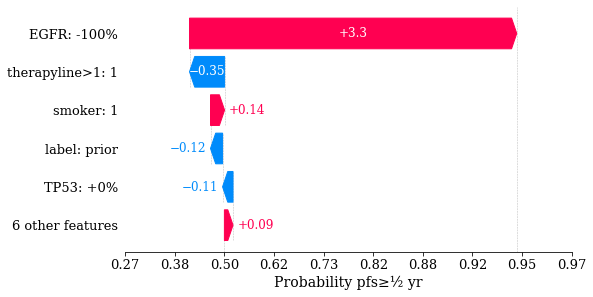

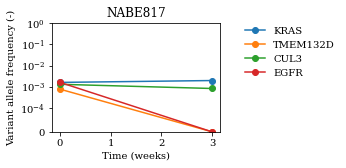

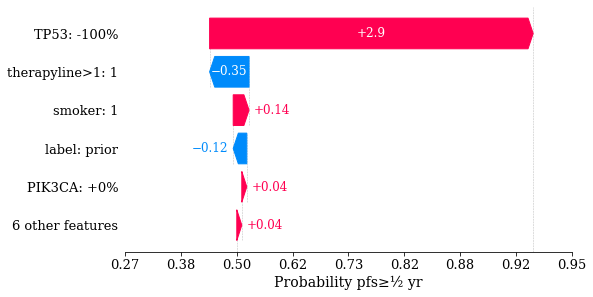

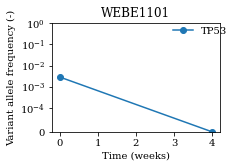

[<Figure size 576x324 with 1 Axes>, <Figure size 576x324 with 1 Axes>]

In [60]:
explain(
    m,
    X_test.loc[worst2_y0, features],
    X_test_raw,
    save_path="figs/pfs/clinical_multitrack/worst",
)